In [1]:
# ==== Librerías principales ====
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ==== Comprobación de dispositivo ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

# ==== Semillas para reproducibilidad ====
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

# Configuración de gráficos
plt.style.use("seaborn-v0_8")


Usando dispositivo: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


In [5]:
# Carga y comprobación inicial de datos para LSTM (Amazon_stock_data.csv)
import pandas as pd
import numpy as np
from datetime import datetime

path = r"C:\Users\jhean\Documents\Universidad\IA2\Lab03\Amazon_stock_data.csv"
df = pd.read_csv(path)

df.columns = [c.strip().replace(" ", "_") for c in df.columns]

date_col_candidates = [c for c in df.columns if c.lower() in ["date", "fecha", "timestamp", "datetime"]]
date_col = date_col_candidates[0] if date_col_candidates else None
if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.sort_values(by=date_col).reset_index(drop=True)
else:
    date_col = "idx_time"
    df[date_col] = pd.RangeIndex(start=0, stop=len(df), step=1)

#Tipos y valores faltantes
dtypes = df.dtypes.astype(str).to_frame("dtype")
na_counts = df.isna().sum().to_frame("na_count")
summary_dtypes_na = dtypes.join(na_counts)

#Duplicados?
full_dupes = int(df.duplicated().sum())
date_dupes = int(df.duplicated(subset=[date_col]).sum()) if date_col in df.columns else 0

#Estadisticas numericas basicas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
desc = df[numeric_cols].describe().T if numeric_cols else pd.DataFrame()

#Mostrar los dataframes
preview_rows = min(10, len(df))
print("Vista previa (primeras filas ordenadas por fecha):")
display(df.head(preview_rows))
print("Tipos y valores faltantes por columna:")
display(summary_dtypes_na)
if not desc.empty:
    print("Estadísticas descriptivas (columnas numéricas):")
    display(desc)

#Informe textual
print("Archivo cargado:", path)
print("Filas x Columnas:", df.shape)
print("Columna de fecha detectada:", date_col)
print("Duplicados de fila completos:", full_dupes)
print("Duplicados por fecha:", date_dupes)
print("Columnas numéricas:", numeric_cols)


Vista previa (primeras filas ordenadas por fecha):


,Date,Close,High,Low,Open,Volume
0,1997-05-15,0.097917,0.125000,0.096354,0.121875,1443120000
1,1997-05-16,0.086458,0.098958,0.085417,0.098438,294000000
2,1997-05-19,0.085417,0.088542,0.081250,0.088021,122136000
3,1997-05-20,0.081771,0.087500,0.081771,0.086458,109344000
4,1997-05-21,0.071354,0.082292,0.068750,0.081771,377064000
5,1997-05-22,0.069792,0.072396,0.065625,0.071875,235536000
6,1997-05-23,0.075000,0.076042,0.066667,0.070313,318744000
7,1997-05-27,0.079167,0.082292,0.072917,0.075521,173952000
8,1997-05-28,0.076563,0.081771,0.076563,0.081250,91488000
9,1997-05-29,0.075260,0.077083,0.073958,0.077083,69456000


Tipos y valores faltantes por columna:


,dtype,na_count
Date,datetime64[ns],0
Close,float64,0
High,float64,0
Low,float64,0
Open,float64,0
Volume,int64,0


Estadísticas descriptivas (columnas numéricas):


,count,mean,std,min,25%,50%,75%,max
Close,7107.0,4.347128e+01,6.146518e+01,6.979200e-02,2.132375e+00,9.276500e+00,8.118850e+01,2.420600e+02
High,7107.0,4.398791e+01,6.217350e+01,7.239600e-02,2.168875e+00,9.408500e+00,8.190000e+01,2.425200e+02
Low,7107.0,4.292448e+01,6.072232e+01,6.562500e-02,2.094375e+00,9.165000e+00,8.002525e+01,2.380300e+02
Open,7107.0,4.347640e+01,6.147804e+01,7.031300e-02,2.125500e+00,9.278000e+00,8.115000e+01,2.390200e+02
Volume,7107.0,1.345628e+08,1.369077e+08,9.744000e+06,6.201500e+07,9.922000e+07,1.542450e+08,2.086584e+09


Archivo cargado: C:\Users\jhean\Documents\Universidad\IA2\Lab03\Amazon_stock_data.csv
Filas x Columnas: (7107, 6)
Columna de fecha detectada: Date
Duplicados de fila completos: 0
Duplicados por fecha: 0
Columnas numéricas: ['Close', 'High', 'Low', 'Open', 'Volume']


In [23]:
#Seleccion de columnas
feat_cols = ['Open','High','Low','Close','Volume']
target_col = 'Close' # predecimos el precio de cierre

assert all(c in df.columns for c in feat_cols), "Faltan columnas esperadas"
assert target_col in df.columns, "Falta columna objetivo"

#Division de datos
N = len(df)
n_train = int(N * 0.70)
n_val   = int(N * 0.15)
n_test  = N - n_train - n_val

df_train = df.iloc[:n_train].copy()
df_val   = df.iloc[n_train:n_train+n_val].copy()
df_test  = df.iloc[n_train+n_val:].copy()

print(f"Split -> train:{len(df_train)} val:{len(df_val)} test:{len(df_test)}")

#Escalado MinMax
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_x.fit_transform(df_train[feat_cols].values)
y_train = scaler_y.fit_transform(df_train[[target_col]].values)

X_val   = scaler_x.transform(df_val[feat_cols].values)
y_val   = scaler_y.transform(df_val[[target_col]].values)

X_test  = scaler_x.transform(df_test[feat_cols].values)
y_test  = scaler_y.transform(df_test[[target_col]].values)

#Crear secuencias (ventanas)
import numpy as np

def make_sequences(X, y, lookback=180, horizon=1):
    """
    X: np.array [T, F]
    y: np.array [T, 1]
    lookback: timesteps por ventana
    horizon: pasos hacia adelante a predecir (1 = siguiente)
    return: X_seq [N, lookback, F], y_seq [N, 1]
    """
    xs, ys = [], []
    T = len(X)
    end = T - lookback - horizon + 1
    for i in range(end):
        xs.append(X[i:i+lookback])
        ys.append(y[i+lookback+horizon-1])
    return np.asarray(xs, dtype=np.float32), np.asarray(ys, dtype=np.float32)

LOOKBACK = 180
HORIZON  = 1

Xtr_seq, ytr_seq = make_sequences(X_train, y_train, LOOKBACK, HORIZON)
Xva_seq, yva_seq = make_sequences(X_val,   y_val,   LOOKBACK, HORIZON)
Xte_seq, yte_seq = make_sequences(X_test,  y_test,  LOOKBACK, HORIZON)

# Dataset/Dataloader PyTorch
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # [N, L, F]
        self.y = torch.tensor(y, dtype=torch.float32)  # [N, 1]
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = TimeSeriesDataset(Xtr_seq, ytr_seq)
val_ds   = TimeSeriesDataset(Xva_seq, yva_seq)
test_ds  = TimeSeriesDataset(Xte_seq, yte_seq)

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


Split -> train:4974 val:1066 test:1067


In [24]:
import torch
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 512,
                 num_layers: int = 2, bidirectional: bool = True,
                 dropout: float = 0.2):
        """
        input_size: # de features por timestep (p.ej., 5 -> Open, High, Low, Close, Volume)
        hidden_size: tamaño del estado oculto LSTM
        num_layers: # de capas LSTM apiladas
        bidirectional: True = LSTM bidireccional
        dropout: aplicado entre capas LSTM (si num_layers > 1) y antes de la capa final
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        # LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )

        # Capa final (usa la representación del último timestep)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * self.num_directions, 1)  # predicción escalar (Close)

        self._init_weights()

    def _init_weights(self):
        # Inicialización: ortogonal para recurrentes, xavier/kaiming para lineales
        for name, param in self.lstm.named_parameters():
            if "weight_hh" in name:
                nn.init.orthogonal_(param)           # recurrente
            elif "weight_ih" in name:
                nn.init.xavier_uniform_(param)       # entrada->oculto
            elif "bias" in name:
                nn.init.zeros_(param)

        nn.init.kaiming_uniform_(self.fc.weight, nonlinearity="linear")
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        """
        x: tensor [B, L, F]
        retorna: predicción [B, 1]
        """
        # Salida de LSTM: output [B, L, H*num_directions]
        output, _ = self.lstm(x)
        # Tomamos el último timestep
        last = output[:, -1, :]                       # [B, H*num_directions]
        last = self.dropout(last)
        yhat = self.fc(last)                          # [B, 1]
        return yhat


In [25]:
INPUT_SIZE = Xtr_seq.shape[2]   # F
HIDDEN_SIZE = 512
NUM_LAYERS = 2
BIDIR = True
DROPOUT = 0.2

model = LSTMRegressor(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIR,
    dropout=DROPOUT
).to(device)

# Conteo de parámetros (opcional)
def count_params(m): 
    return sum(p.numel() for p in m.parameters() if p.requires_grad)
print(model)
print("Parámetros entrenables:", count_params(model))


LSTMRegressor(
  (lstm): LSTM(5, 512, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)
Parámetros entrenables: 8426497


In [26]:
# ==== Entrenamiento/validación sin guardar modelo ====
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

MAX_EPOCHS = 40
PATIENCE   = 6
CLIP_NORM  = 1.0

USE_AMP = (device.type == "cuda")
try:
    from torch.amp import GradScaler, autocast
    scaler = GradScaler(enabled=USE_AMP)
    def autocast_ctx(): return autocast(device_type="cuda", enabled=USE_AMP)
except Exception:
    from torch.cuda.amp import GradScaler, autocast
    scaler = GradScaler(enabled=USE_AMP)
    def autocast_ctx(): return autocast(enabled=USE_AMP)

def invert_scale(y_scaled: np.ndarray):
    return scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).reshape(-1)

def mae_rmse_real(y_true_scaled: np.ndarray, y_pred_scaled: np.ndarray):
    y_true = invert_scale(y_true_scaled)
    y_pred = invert_scale(y_pred_scaled)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return mae, rmse

def run_epoch(loader, train: bool):
    model.train(train)
    total_loss, total_count = 0.0, 0
    y_true_all, y_pred_all = [], []

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        with autocast_ctx():
            y_hat = model(X)
            loss = criterion(y_hat, y)

        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()

        bs = y.size(0)
        total_loss += loss.item() * bs
        total_count += bs
        y_true_all.append(y.detach().cpu().numpy())
        y_pred_all.append(y_hat.detach().cpu().numpy())

    avg_loss = total_loss / max(1, total_count)
    y_true_all = np.concatenate(y_true_all, axis=0).reshape(-1)
    y_pred_all = np.concatenate(y_pred_all, axis=0).reshape(-1)
    mae_real, rmse_real = mae_rmse_real(y_true_all, y_pred_all)
    return avg_loss, mae_real, rmse_real

history = {"train_loss": [], "val_loss": [], "train_MAE": [], "train_RMSE": [], "val_MAE": [], "val_RMSE": []}

best_val_mae = float("inf")
no_improve = 0

for epoch in range(1, MAX_EPOCHS + 1):
    tr_loss, tr_mae, tr_rmse = run_epoch(train_loader, train=True)
    va_loss, va_mae, va_rmse = run_epoch(val_loader, train=False)
    scheduler.step(va_loss)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_MAE"].append(tr_mae)
    history["train_RMSE"].append(tr_rmse)
    history["val_MAE"].append(va_mae)
    history["val_RMSE"].append(va_rmse)

    print(f"[{epoch:02d}/{MAX_EPOCHS}] "
          f"loss_tr={tr_loss:.5f} val_loss={va_loss:.5f} "
          f"| MAE_tr={tr_mae:.3f} RMSE_tr={tr_rmse:.3f} "
          f"| MAE_val={va_mae:.3f} RMSE_val={va_rmse:.3f}")

    # Early stopping por paciencia
    if va_mae < best_val_mae - 1e-6:
        best_val_mae = va_mae
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stopping activado.")
            break


[01/40] loss_tr=0.00758 val_loss=0.13422 | MAE_tr=1.867 RMSE_tr=3.672 | MAE_val=11.650 RMSE_val=15.445
[02/40] loss_tr=0.00039 val_loss=0.22477 | MAE_tr=0.597 RMSE_tr=0.831 | MAE_val=16.569 RMSE_val=19.988
[03/40] loss_tr=0.00025 val_loss=0.07389 | MAE_tr=0.464 RMSE_tr=0.663 | MAE_val=7.564 RMSE_val=11.459
[04/40] loss_tr=0.00025 val_loss=0.07037 | MAE_tr=0.452 RMSE_tr=0.670 | MAE_val=7.508 RMSE_val=11.183
[05/40] loss_tr=0.00025 val_loss=0.07767 | MAE_tr=0.466 RMSE_tr=0.664 | MAE_val=8.531 RMSE_val=11.746
[06/40] loss_tr=0.00046 val_loss=0.04541 | MAE_tr=0.638 RMSE_tr=0.900 | MAE_val=5.680 RMSE_val=8.981
[07/40] loss_tr=0.00059 val_loss=0.14288 | MAE_tr=0.774 RMSE_tr=1.027 | MAE_val=13.133 RMSE_val=15.935
[08/40] loss_tr=0.00036 val_loss=0.06727 | MAE_tr=0.587 RMSE_tr=0.803 | MAE_val=7.591 RMSE_val=10.933
[09/40] loss_tr=0.00019 val_loss=0.04711 | MAE_tr=0.377 RMSE_tr=0.582 | MAE_val=5.758 RMSE_val=9.150
[10/40] loss_tr=0.00018 val_loss=0.03438 | MAE_tr=0.394 RMSE_tr=0.571 | MAE_val=5

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# --- Helpers (usamos los que ya definimos) ---
def invert_scale(y_scaled: np.ndarray):
    return scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).reshape(-1)

def mae_rmse_mape_real(y_true_scaled: np.ndarray, y_pred_scaled: np.ndarray, eps=1e-8):
    y_true = invert_scale(y_true_scaled)
    y_pred = invert_scale(y_pred_scaled)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100.0
    return mae, rmse, mape, y_true, y_pred

# --- Evaluación en TEST ---
model.eval()
y_true_all, y_pred_all = [], []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        with autocast_ctx():
            y_hat = model(X)  # [B,1] en escala minmax
        y_true_all.append(y.cpu().numpy())
        y_pred_all.append(y_hat.cpu().numpy())

y_true_scaled = np.concatenate(y_true_all, axis=0).reshape(-1)
y_pred_scaled = np.concatenate(y_pred_all, axis=0).reshape(-1)

test_MAE, test_RMSE, test_MAPE, y_true_real, y_pred_real = mae_rmse_mape_real(
    y_true_scaled, y_pred_scaled
)
print(f"TEST  MAE:  {test_MAE:.4f}")
print(f"TEST  RMSE: {test_RMSE:.4f}")
print(f"TEST  MAPE: {test_MAPE:.2f}%")


TEST  MAE:  24.8744
TEST  RMSE: 29.9434
TEST  MAPE: 14.30%


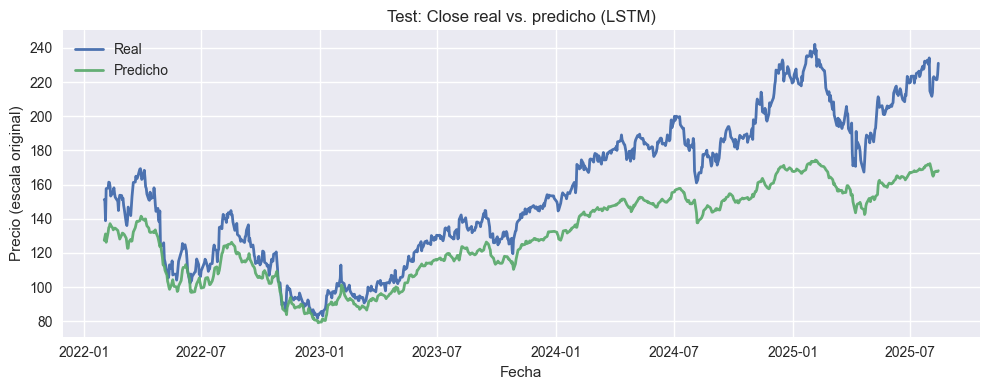

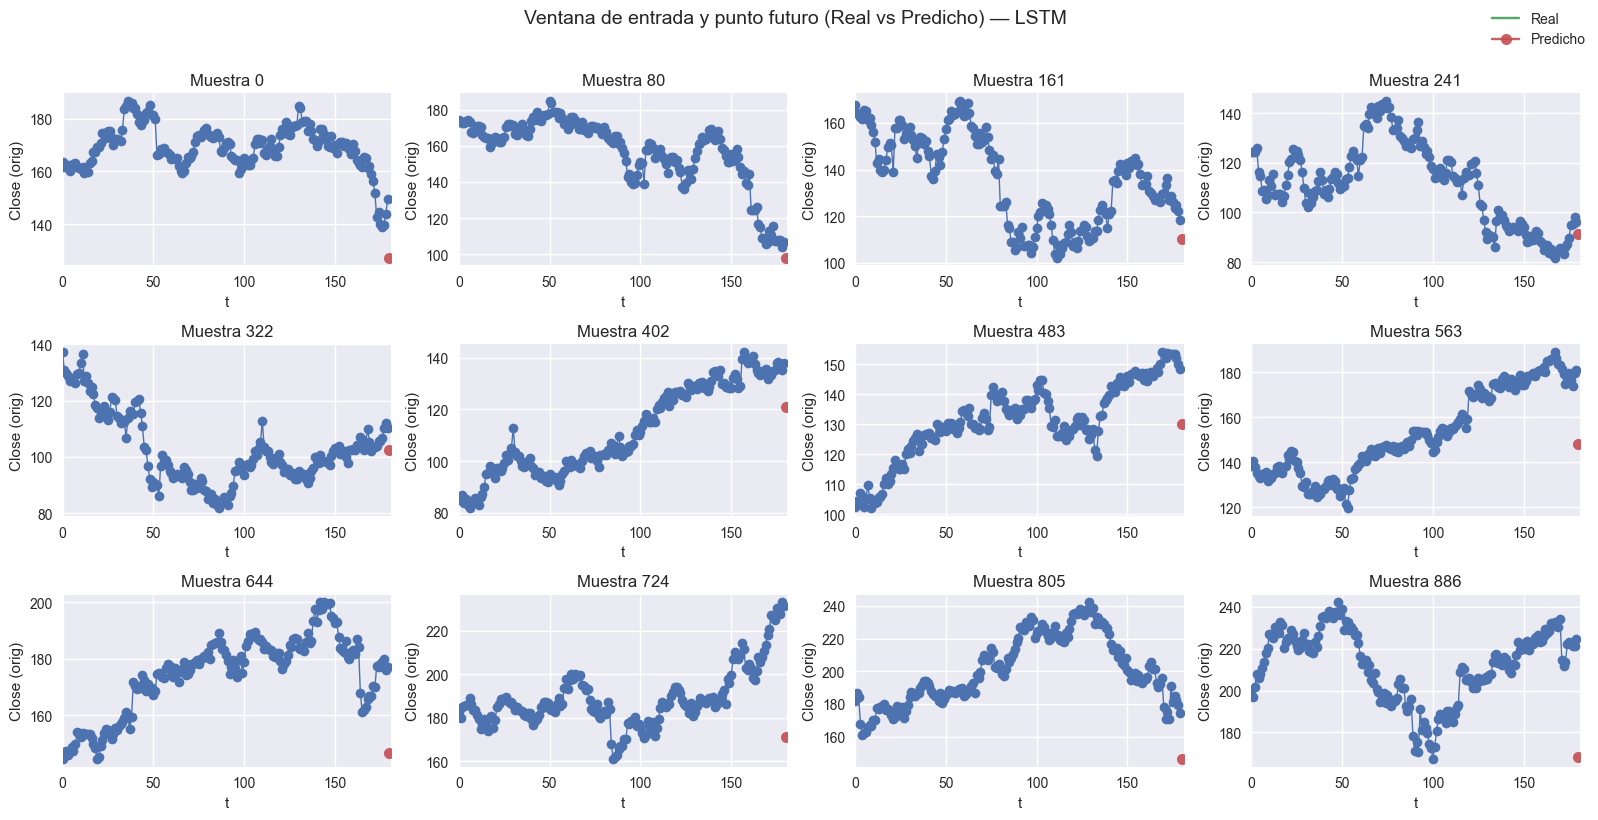

In [29]:
# =======================
# GRÁFICAS DE TEST (serie y rejilla)
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# --- helpers de autocast (fallback si no existe) ---
try:
    autocast_ctx  # ya definida
except NameError:
    def autocast_ctx():
        class _Dummy:
            def __enter__(self): return None
            def __exit__(self, *args): return False
        return _Dummy()

# --- 1) Predicciones en TEST (escala normalizada) ---
model.eval()
y_true_s, y_pred_s = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        with autocast_ctx():
            pred = model(xb)                 # [B, 1]
        y_true_s.append(yb.numpy())          # CPU numpy
        y_pred_s.append(pred.cpu().numpy())

y_true_s = np.concatenate(y_true_s, axis=0)  # [M, 1]
y_pred_s = np.concatenate(y_pred_s, axis=0)  # [M, 1]

# --- 2) Desescalar a valores originales ---
y_true = scaler_y.inverse_transform(y_true_s).ravel()
y_pred = scaler_y.inverse_transform(y_pred_s).ravel()

# --- 3) Fechas alineadas para test ---
# df_test proviene del split temporal que hiciste; date_col fue detectada al cargar el CSV
dates_test_seq = pd.to_datetime(df_test[date_col].values)
# La primera predicción corresponde a la fecha en posición LOOKBACK
dates_pred = dates_test_seq[LOOKBACK : LOOKBACK + len(y_true)]

# --- 4) Gráfico: serie completa test (real vs predicho) ---
plt.figure(figsize=(10,4))
plt.plot(dates_pred, y_true, label="Real", linewidth=2)
plt.plot(dates_pred, y_pred, label="Predicho", linewidth=2, alpha=0.9)
plt.title("Test: Close real vs. predicho (LSTM)")
plt.xlabel("Fecha"); plt.ylabel("Precio (escala original)")
plt.legend(); plt.tight_layout()
plt.show()

# --- 5) Rejilla: ventana de entrada + punto futuro (Real vs Predicho) ---
# índice de 'Close' en tus features
try:
    close_idx = feat_cols.index("Close")
except ValueError:
    raise ValueError("No se encontró 'Close' en feat_cols. Verifica la lista de features.")

def inv_transform_X_seq(X_seq_scaled, scaler_X):
    """
    X_seq_scaled: [T, F] en escala normalizada -> devuelve [T, F] en escala original.
    """
    T, F = X_seq_scaled.shape
    x_flat = X_seq_scaled.reshape(-1, F)
    x_inv  = scaler_X.inverse_transform(x_flat)
    return x_inv.reshape(T, F)

# Muestras a graficar desde el conjunto de test ya preparado (Xte_seq / yte_seq)
N_PLOTS = 12
ROWS, COLS = 3, 4
idxs = np.linspace(0, len(Xte_seq)-1, N_PLOTS, dtype=int) if len(Xte_seq) >= N_PLOTS else np.arange(len(Xte_seq))

fig, axes = plt.subplots(ROWS, COLS, figsize=(16, 8))
axes = axes.ravel()

for k, ax in enumerate(axes[:len(idxs)]):
    i = idxs[k]

    # Secuencia de entrada (T, F) en original
    x_seq_inv = inv_transform_X_seq(Xte_seq[i], scaler_x)  # [T, F]
    close_seq = x_seq_inv[:, close_idx]                    # [T]

    # Punto real y predicho (un paso adelante si HORIZON=1)
    y_real = scaler_y.inverse_transform(yte_seq[i].reshape(1, -1)).ravel()
    with torch.no_grad():
        xb_i = torch.from_numpy(Xte_seq[i:i+1]).to(device)  # [1, L, F]
        with autocast_ctx():
            pred_i = model(xb_i).cpu().numpy()
    y_hat = scaler_y.inverse_transform(pred_i).ravel()

    # Eje temporal relativo
    t = np.arange(len(close_seq))

    # Serie de la ventana
    ax.plot(t, close_seq, marker="o", linewidth=1)

    # Marcar el punto futuro (después de la ventana)
    t_future = len(close_seq)  # siguiente paso
    ax.plot([t_future], [y_real[0]], marker="x", markersize=8, label="Real")
    ax.plot([t_future], [y_hat[0]], marker="o", markersize=8, alpha=0.9, label="Predicho")

    ax.set_title(f"Muestra {i}")
    ax.set_xlabel("t"); ax.set_ylabel("Close (orig)")
    ax.grid(True)
    ax.set_xlim(0, len(close_seq)+1)

# ocultar ejes sobrantes
for j in range(len(idxs), len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper right")
plt.suptitle("Ventana de entrada y punto futuro (Real vs Predicho) — LSTM", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()
